# Tarea 1: Classificaton Fine-tuning

In [ ]:
!pip install -q  transformers==4.45.0 datasets==3.6.0 accelerate==0.34.0 peft==0.13.2 bitsandbytes==0.45.5 trl==0.11.2 sentencepiece==0.2.0 einops==0.8.1

In [ ]:
# Librerías

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

import torch
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs available:", torch.cuda.device_count())

import os
from time import time
from datasets import *
from transformers import *
from sklearn.metrics import *
import matplotlib.pyplot as plt

Is CUDA available: True
CUDA version: 12.4
Number of GPUs available: 1


/usr/local/lib/python3.11/dist-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


## Dataset

El split **MNLI** del dataset **GLUE** consiste en un par de oraciones (premisa e hipótesis) y una etiqueta indicando la relación entre ellas:

- _Entailment_: La hipótesis es una conclusión lógica de la premisa.
- _Neutral_: La hipótesis no puede ser determinada como verdadera o falsa basada en la premisa.
- _Contradiction_: La hipótesis contradice la premisa.

Además, este split contiene diferentes subconjuntos. Principalmente, usaremos el de _train_ para entrenar y los de _validation_ para evaluar la calidad del modelo. Los de _test_ los omitiremos para este trabajo.
- _Train_: Dataset que usaremos para entrenar el modelo.
- _MNLI-matched_ (MNLI-m): Dataset de validación creado a partir de las mismas categorías de los del conjunto de entrenamiento (e.g., noticias, ficción).
- _MNLI-mismatched_ (MNLI-mm): Dataset de validación creado a partir de diferentes categorías de los del conjunto de entrenamiento (e.g., discursos políticos, cartas).

Aquí la ficha del dataset para que podáis explorarla: https://huggingface.co/datasets/nyu-mll/glue

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

dataset = load_dataset("glue", "mnli")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

Con el único motivo de no demorar los tiempos de entrenamiento. Filtraremos el dataset y nos quedaremos solo con los registros que tenga longitud del campo _premise_ inferior a 20.

El resto de la práctica se pide trabajarla sobre la variable `ds_tarea`.

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

def filter_rows(x):
    return len(x['premise'])<20
ds_tarea = dataset.filter(filter_rows)

assert len(ds_tarea['train']) == 13635
assert len(ds_tarea['validation_matched']) == 413
assert len(ds_tarea['validation_mismatched']) == 296

ds_tarea

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 296
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 382
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 288
    })
})

## Modeling

En este apartado es donde tendréis que realizar todo el trabajo de la práctica. El formato, el análisis, el modelo escogido y cualquier proceso intermedio que consideréis es totalmente libre. Sin embargo, hay algunas pautas que tendréis que cumplir:

- La variable `model_checkpoint` debe almacenar el nombre del modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `model` y la variable `tokenizer` almacenarán, respectivamente, el modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `trainer` almacenará el _Trainer_ de 🤗 que, en la siguiente sección utilizaréis para entrenar el modelo.
- Debe existir una función llamada `preprocess_function` que realice la tokenización y, si lo consideráis oportuno, transformaciones de las _features_.

Nota: En el _tokenizer_, es obligatorio que el argumento `padding` sea distinto de `False` y que su salida sean **tensores** de pytorch.

In [ ]:
model_checkpoint =  "roberta-base" # "bert-base-uncased" #"distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model =  AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = 3)

def preprocess_function(x):
    return tokenizer(x["premise"], x["hypothesis"], padding=True, truncation=True, return_tensors='pt')


ds_tokenized = ds_tarea.map(preprocess_function, batched = True)

os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,                 # Prueba subir 1 epoch
    weight_decay=0.01,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    save_strategy="epoch",
    metric_for_best_model="eval_accuracy",
    per_device_eval_batch_size=32
)



trainer = Trainer(
    model,
    training_args,
    train_dataset=ds_tokenized['train'],
    tokenizer=tokenizer,

)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.45.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/vocab.json
loading file

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## Training

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

start = time()

trainer.train()

end = time()
print(f">>>>>>>>>>>>> elapsed time: {(end-start)/60:.0f}m")

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 13,635
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1,708
  Number of trainable parameters = 124,647,939


Step,Training Loss
500,0.645200
1000,0.376400
1500,0.273500


Saving model checkpoint to ./results/checkpoint-427
Configuration saved in ./results/checkpoint-427/config.json
Model weights saved in ./results/checkpoint-427/model.safetensors
tokenizer config file saved in ./results/checkpoint-427/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-427/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-854
Configuration saved in ./results/checkpoint-854/config.json
Model weights saved in ./results/checkpoint-854/model.safetensors
tokenizer config file saved in ./results/checkpoint-854/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-854/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1281
Configuration saved in ./results/checkpoint-1281/config.json
Model weights saved in ./results/checkpoint-1281/model.safetensors
tokenizer config file saved in ./results/checkpoint-1281/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1281/special_tokens_ma

>>>>>>>>>>>>> elapsed time: 9m


## Evaluation

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

print(f"**** EVALUACIÓN ****")
print(f"********\nTokenizer config:\n{tokenizer}")
print(f"\n\n********\nModel config:\n{model.config}")
print(f"\n\n********\nTrainer arguments:\n{trainer.args}")

**** EVALUACIÓN ****
********
Tokenizer config:
RobertaTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}


********
Model config:
RobertaConfig {
  "_name_or_pa

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

sample = ds_tarea['validation_matched'][0]
inputs = preprocess_function(sample)
for key, value in inputs.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} es una instancia de torch.Tensor")
    else:
        print(f"{key} no es una instancia de torch.Tensor")

input_ids es una instancia de torch.Tensor
attention_mask es una instancia de torch.Tensor


In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict(x):
    inputs = preprocess_function(x)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        return {'prediction': predictions.item()}

ds_predictions = ds_tarea.map(predict)

assert len(ds_predictions['train']) == 13635
assert len(ds_predictions['validation_matched']) == 413
assert len(ds_predictions['validation_mismatched']) == 296

ds_predictions

Map:   0%|          | 0/13635 [00:00<?, ? examples/s]

Map:   0%|          | 0/413 [00:00<?, ? examples/s]

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 296
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 382
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 288
    })
})

*** train ***


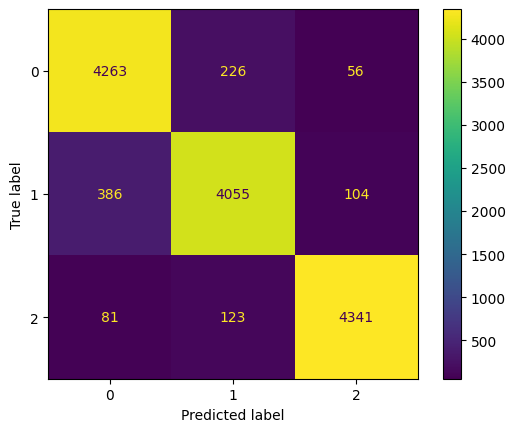

*** validation_matched ***


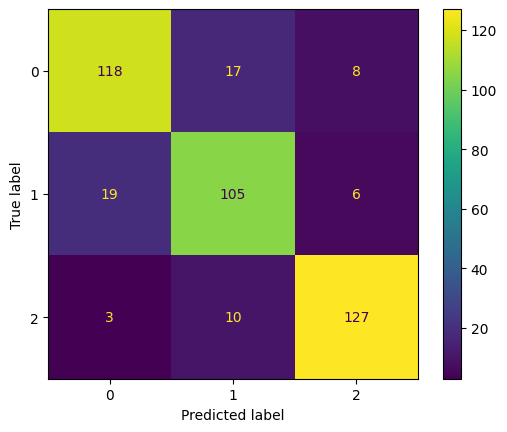

*** validation_mismatched ***


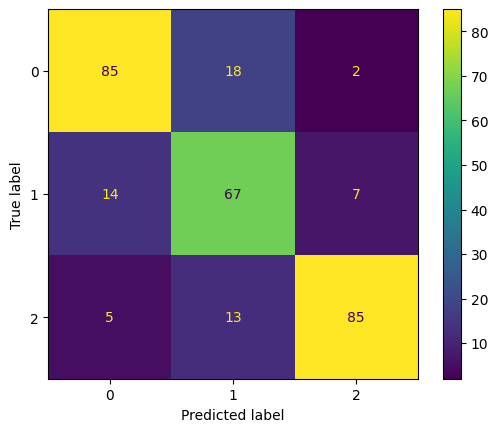

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print(f"*** {subset} ***")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

metrics = {}
for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    pre = precision_score(y_true=y_true, y_pred=y_pred, average=None)
    rec = recall_score(y_true=y_true, y_pred=y_pred, average=None)
    metrics[subset] = [acc] + pre.tolist() + rec.tolist()
    print(f"Subset: {subset}:")
    print(f"Accuracy: {acc:.2f} | Precision0: {pre[0]:.2f} | Precision1: {pre[1]:.2f} | Precision2: {pre[2]:.2f} | Recall0: {rec[0]:.2f} | Recall1: {rec[1]:.2f} | Recall2: {rec[2]:.2f}")
    print("-----\n")

Subset: train:
Accuracy: 0.93 | Precision0: 0.90 | Precision1: 0.92 | Precision2: 0.96 | Recall0: 0.94 | Recall1: 0.89 | Recall2: 0.96
-----

Subset: validation_matched:
Accuracy: 0.85 | Precision0: 0.84 | Precision1: 0.80 | Precision2: 0.90 | Recall0: 0.83 | Recall1: 0.81 | Recall2: 0.91
-----

Subset: validation_mismatched:
Accuracy: 0.80 | Precision0: 0.82 | Precision1: 0.68 | Precision2: 0.90 | Recall0: 0.81 | Recall1: 0.76 | Recall2: 0.83
-----



### Criterio de evaluación

La **nota final de la tarea1** estará relacionada con el resultado de las métricas de vuestro modelo en la combinación de *accuracy*, *precision* y *recall* para cada _split_ de datos.

El criterio de evaluación será el siguiente:
- La tarea1 se aprobará si el notebook se entrega sin fallos y con un modelo entrenado (independientemente de sus métricas).
- La tarea1 tiene un 10 si se cumple que las métricas de vuestro modelo entrenado igualan o superan los siguientes umbrales:

| Subset               | Accuracy | Precision0 | Precision1 | Precision2 | Recall0 | Recall1 | Recall2 |
|----------------------|----------|------------|------------|------------|---------|---------|---------|
| validation_matched    | 0.78     | 0.78       | 0.76       | 0.85       | 0.80    | 0.77    | 0.81    |
| validation_mismatched | 0.79     | 0.70       | 0.70       | 0.70       | 0.65    | 0.71    | 0.85    |

- Por cada valor inferior a dicha métrica, la tarea pierde 0.5 puntos (máximo 5.0 puntos de pérdida).

Nota: La nota que se calcula a continuación es orientativa y podría verse reducida en función del código de la entrega.

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

def calculo_nota(metric):

    vm_acc = float(metric['validation_matched'][0])
    vm_pre0 = float(metric['validation_matched'][1])
    vm_pre1 = float(metric['validation_matched'][2])
    vm_pre2 = float(metric['validation_matched'][3])
    vm_rec0 = float(metric['validation_matched'][4])
    vm_rec1 = float(metric['validation_matched'][5])
    vm_rec2 = float(metric['validation_matched'][6])
    vmm_acc = float(metric['validation_mismatched'][0])
    vmm_pre0 = float(metric['validation_mismatched'][1])
    vmm_pre1 = float(metric['validation_mismatched'][2])
    vmm_pre2 = float(metric['validation_mismatched'][3])
    vmm_rec0 = float(metric['validation_mismatched'][4])
    vmm_rec1 = float(metric['validation_mismatched'][5])
    vmm_rec2 = float(metric['validation_mismatched'][6])

    thresholds = {
        'vm_acc': 0.78, 'vm_pre0': 0.78, 'vm_pre1': 0.76, 'vm_pre2': 0.85,
        'vm_rec0': 0.80, 'vm_rec1': 0.77, 'vm_rec2': 0.81,
        'vmm_acc': 0.79, 'vmm_pre0': 0.70, 'vmm_pre1': 0.70, 'vmm_pre2': 0.70,
        'vmm_rec0': 0.65, 'vmm_rec1': 0.71, 'vmm_rec2': 0.85,
    }
    values = {
        'vm_acc': vm_acc, 'vm_pre0': vm_pre0, 'vm_pre1': vm_pre1, 'vm_pre2': vm_pre2,
        'vm_rec0': vm_rec0, 'vm_rec1': vm_rec1, 'vm_rec2': vm_rec2,
        'vmm_acc': vmm_acc, 'vmm_pre0': vmm_pre0, 'vmm_pre1': vmm_pre1, 'vmm_pre2': vmm_pre2,
        'vmm_rec0': vmm_rec0, 'vmm_rec1': vmm_rec1, 'vmm_rec2': vmm_rec2,
    }

    nota = 10
    for key in thresholds:
        if values[key] < thresholds[key]:
            nota -= 0.5
    return max(nota, 5.0)

print(f"Tu nota de la tarea1 es: {calculo_nota(metrics)}")

Tu nota de la tarea1 es: 9.0
